# 비디오 메타데이터 분석 EDA
클린 샘플 리스트를 기반으로 각 샘플의 비디오 메타데이터(FPS, 프레임수, 해상도, 길이 등)를 분석합니다.

## 1. 필요 라이브러리 임포트
비디오 메타데이터 추출을 위해 OpenCV(cv2), pandas, numpy 등 필요한 라이브러리를 import합니다.

In [31]:
# 1. 필요 라이브러리 임포트
import os
from pathlib import Path
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm

## 2. 클린 샘플 리스트 로드 및 비디오 경로 확인
클린 샘플 리스트(train_clean.csv)를 불러오고, 각 샘플의 비디오 파일 경로를 확인합니다.

In [32]:
# 2. 클린 샘플 리스트 로드 및 비디오 경로 확인
clean_csv_path = '../EDA/train_clean.csv'
df_clean = pd.read_csv(clean_csv_path)

# 실제 폴더 구조에 맞게 video_dir 생성 (N/{샘플명})
def get_video_dir(cls, sample_id):
    return f"../data/train/raw/video/{cls}/N/{sample_id}"

df_clean['video_dir'] = df_clean.apply(lambda row: get_video_dir(row['class'], row['sample_id']), axis=1)

# video_path: video_dir 내 첫 번째 파일 (확장자 mp4, avi 등만)
def get_first_video_file(video_dir):
    if not os.path.exists(video_dir):
        return None
    files = [f for f in os.listdir(video_dir) if f.lower().endswith(('.mp4', '.avi', '.mov', '.mkv'))]
    if len(files) == 0:
        return None
    return os.path.join(video_dir, files[0])

df_clean['video_path'] = df_clean['video_dir'].apply(get_first_video_file)

display(df_clean[['sample_id', 'class', 'video_dir', 'video_path']].head())

,sample_id,class,video_dir,video_path
0,02181_H_A_N_C1,N/N,../data/train/raw/video/N/N/N/02181_H_A_N_C1,None
1,02117_H_A_N_C6,N/N,../data/train/raw/video/N/N/N/02117_H_A_N_C6,None
2,02497_H_A_N_C5,N/N,../data/train/raw/video/N/N/N/02497_H_A_N_C5,None
3,02604_H_A_N_C2,N/N,../data/train/raw/video/N/N/N/02604_H_A_N_C2,None
4,00322_H_A_N_C3,N/N,../data/train/raw/video/N/N/N/00322_H_A_N_C3,None


## 3. 비디오 메타데이터(FPS, 프레임수, 해상도, 길이) 추출 함수 구현
OpenCV(cv2)를 이용해 비디오 파일의 FPS, 프레임수, 해상도, 길이(초)를 추출하는 함수를 만듭니다.

In [33]:
# 3. 비디오 메타데이터 추출 함수
def get_video_metadata(video_path):
    if not video_path or not os.path.exists(video_path):
        return {'fps': None, 'frame_count': None, 'width': None, 'height': None, 'duration': None}
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return {'fps': None, 'frame_count': None, 'width': None, 'height': None, 'duration': None}
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    duration = frame_count / fps if fps > 0 else None
    cap.release()
    return {'fps': fps, 'frame_count': frame_count, 'width': width, 'height': height, 'duration': duration}

# 예시: 첫 번째 유효한 샘플 비디오 메타데이터 출력
first_valid_video_path = df_clean['video_path'].dropna().iloc[0] if df_clean['video_path'].notnull().any() else None
print(get_video_metadata(first_valid_video_path))

{'fps': None, 'frame_count': None, 'width': None, 'height': None, 'duration': None}


## 4. 전체 샘플 비디오 메타데이터 일괄 추출
클린 샘플 리스트의 모든 비디오에 대해 메타데이터를 추출하여 DataFrame에 저장합니다.

In [34]:
# 4. 전체 샘플 비디오 메타데이터 일괄 추출 (경로 규칙 반영)

# 실제 경로 규칙에 맞게 video_path 생성 함수
def get_video_path(row):
    candidates = [
        f"../data/train/raw/video/Y/SY/{row['sample_id']}/{row['sample_id']}.mp4",
        f"../data/train/raw/video/N/N/{row['sample_id']}/{row['sample_id']}.mp4",
        f"../data/train/raw/video/SY/SY/{row['sample_id']}/{row['sample_id']}.mp4"
    ]
    for video_file in candidates:
        if os.path.exists(video_file):
            return video_file
    return None

# video_path 컬럼 생성
df_clean['video_path'] = df_clean.apply(get_video_path, axis=1)

meta_list = []
for idx, row in tqdm(df_clean.iterrows(), total=len(df_clean)):
    if not row['video_path']:
        print(f"[경고] 영상 파일 없음: sample_id={row['sample_id']}, class={row['class']}")
        continue
    meta = get_video_metadata(row['video_path'])
    meta_list.append({
        'sample_id': row['sample_id'],
        'class': row['class'],
        'video_path': row['video_path'],
        **meta
    })
df_video_meta = pd.DataFrame(meta_list)
df_video_meta.to_csv('video_metadata.csv', index=False)
df_video_meta.head()

100%|██████████| 4128/4128 [00:15<00:00, 259.12it/s]


,sample_id,class,video_path,fps,frame_count,width,height,duration
0,02181_H_A_N_C1,N/N,../data/train/raw/video/N/N/02181_H_A_N_C1/021...,10.0,100,1280,720,10.0
1,02117_H_A_N_C6,N/N,../data/train/raw/video/N/N/02117_H_A_N_C6/021...,10.0,100,1280,720,10.0
2,02497_H_A_N_C5,N/N,../data/train/raw/video/N/N/02497_H_A_N_C5/024...,10.0,100,1280,720,10.0
3,02604_H_A_N_C2,N/N,../data/train/raw/video/N/N/02604_H_A_N_C2/026...,10.0,100,1280,720,10.0
4,00322_H_A_N_C3,N/N,../data/train/raw/video/N/N/00322_H_A_N_C3/003...,10.0,100,1280,720,10.0


## 5. 비디오 메타데이터 분포 및 통계 분석
FPS, 프레임수, 해상도, 길이 등 주요 메타데이터의 분포와 통계를 확인합니다.

In [35]:
# 5. 비디오 메타데이터 분포 및 통계 분석
print(df_video_meta.describe())
print('\nFPS 분포:', df_video_meta['fps'].value_counts())
print('\n해상도 분포:', df_video_meta[['width','height']].drop_duplicates().value_counts())

          fps  frame_count   width  height     duration
count  4128.0  4128.000000  4128.0  4128.0  4128.000000
mean     10.0   100.532946  1280.0   720.0    10.053295
std       0.0     8.554385     0.0     0.0     0.855438
min      10.0   100.000000  1280.0   720.0    10.000000
25%      10.0   100.000000  1280.0   720.0    10.000000
50%      10.0   100.000000  1280.0   720.0    10.000000
75%      10.0   100.000000  1280.0   720.0    10.000000
max      10.0   244.000000  1280.0   720.0    24.400000

FPS 분포: fps
10.0    4128
Name: count, dtype: int64

해상도 분포: width  height
1280   720       1
Name: count, dtype: int64


## 6. 클래스별/카메라별 비디오 메타데이터 통계
클래스(class), 카메라(camera)별로 FPS, 길이, 해상도 등의 통계를 집계합니다.

In [36]:
# 6. 클래스별/카메라별 비디오 메타데이터 통계
# 카메라 정보 추출
if 'camera' not in df_video_meta.columns:
    df_video_meta['camera'] = df_video_meta['sample_id'].str.extract(r'_C(\d+)$')

print('클래스별 FPS 평균:')
print(df_video_meta.groupby('class')['fps'].mean())
print('\n카메라별 길이 평균:')
print(df_video_meta.groupby('camera')['duration'].mean())

클래스별 FPS 평균:
class
N/N     10.0
Y/SY    10.0
Name: fps, dtype: float64

카메라별 길이 평균:
camera
1    10.053295
2    10.053295
3    10.053295
4    10.053295
5    10.053295
6    10.053295
7    10.053295
8    10.053295
Name: duration, dtype: float64


## 7. 비디오 메타데이터 시각화
FPS, 길이, 해상도 등 주요 메타데이터의 분포를 시각화합니다.

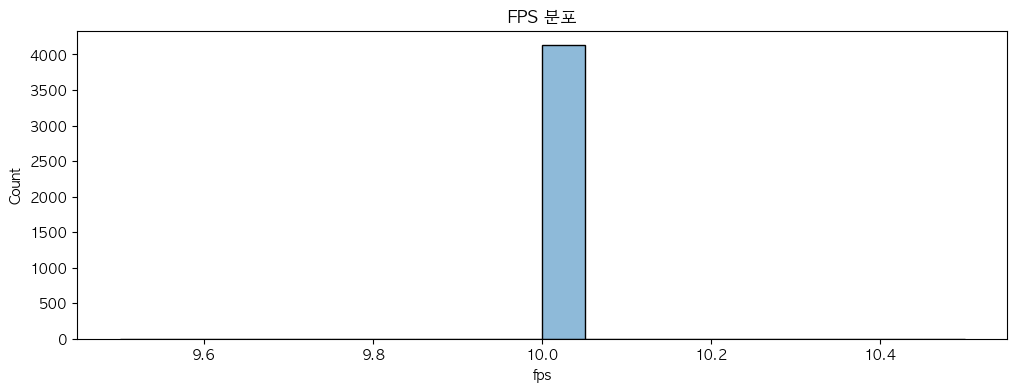

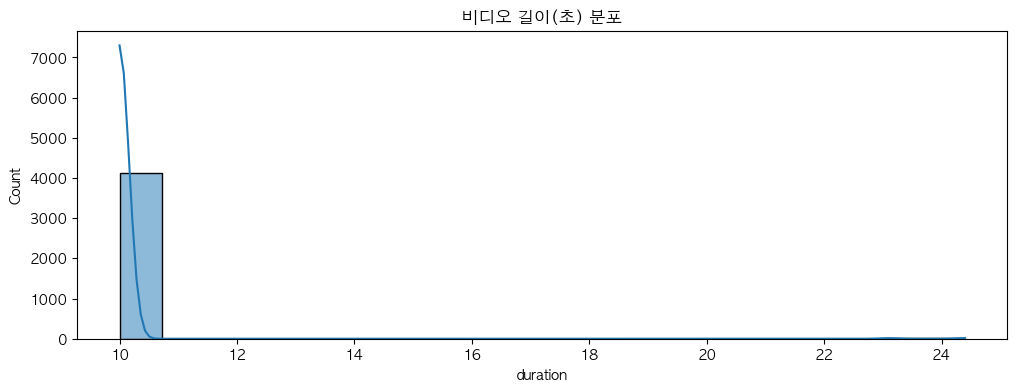

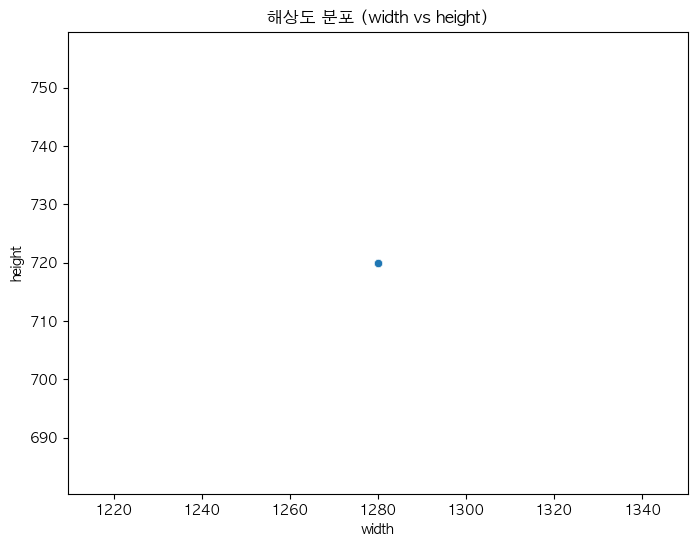

In [37]:
# 7. 비디오 메타데이터 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(12,4))
sns.histplot(df_video_meta['fps'].dropna(), bins=20, kde=True)
plt.title('FPS 분포')
plt.show()

plt.figure(figsize=(12,4))
sns.histplot(df_video_meta['duration'].dropna(), bins=20, kde=True)
plt.title('비디오 길이(초) 분포')
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(x='width', y='height', data=df_video_meta)
plt.title('해상도 분포 (width vs height)')
plt.show()